Homework 3

In [4]:
#usual imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# aaah, to suppress the warnings. I see...
#import warning
#swarnings.filterwarning("ignore")

In [5]:
# load & filter csv file
df = pd.read_csv("AB_NYC_2019.csv") 
allcols = ['neighbourhood_group',
'room_type',
'latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']
df = df[allcols]
df= df.fillna(0)
df

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,40.64749,-73.97237,149,1,9,0.21,6,365
1,Manhattan,Entire home/apt,40.75362,-73.98377,225,1,45,0.38,2,355
2,Manhattan,Private room,40.80902,-73.94190,150,3,0,0.00,1,365
3,Brooklyn,Entire home/apt,40.68514,-73.95976,89,1,270,4.64,1,194
4,Manhattan,Entire home/apt,40.79851,-73.94399,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Private room,40.67853,-73.94995,70,2,0,0.00,2,9
48891,Brooklyn,Private room,40.70184,-73.93317,40,4,0,0.00,2,36
48892,Manhattan,Entire home/apt,40.81475,-73.94867,115,10,0,0.00,1,27
48893,Manhattan,Shared room,40.75751,-73.99112,55,1,0,0.00,6,2


## Q1: mode of neighbourhood_group 

In [6]:
print("the mode of neighborhood group is %s" % df['neighbourhood_group'].mode())
# alternatively
print("Mode: %s" % (df.describe(include=["O"])))

the mode of neighborhood group is 0    Manhattan
dtype: object
Mode:        neighbourhood_group        room_type
count                48895            48895
unique                   5                3
top              Manhattan  Entire home/apt
freq                 21661            25409


Data preparation

In [8]:
np.random.seed(42) #seed RNG 42

from sklearn.model_selection import train_test_split
df_trainval, df_test = train_test_split(df, test_size=0.2, random_state=42) #split train+val [80%], test [20%]
df_train, df_val = train_test_split(df_trainval, test_size=0.25, random_state=42) #split train[60%] val [20%]

#reset, drop index
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_test = df_test["price"]
y_train = df_train["price"]
y_val = df_val["price"]

del df_test["price"]
del df_train["price"]
del df_val["price"]

allcols.remove("price") #remove price from all columns (for Q4+)

## Q2: Correlation matrix

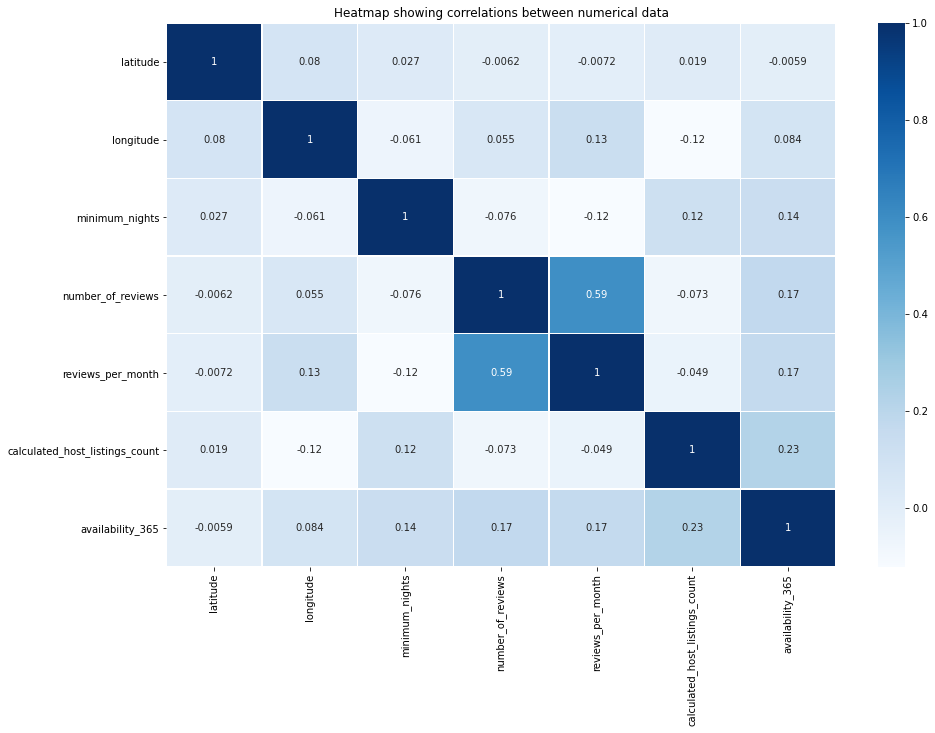

In [9]:
#Visualize Correlation Matrix
df_train.corr() #it's possible to split as well

plt.figure(figsize=(15,10))
sns.heatmap(df_train.corr(),annot=True,linewidths = .5, cmap = "Blues")
plt.title("Heatmap showing correlations between numerical data")
plt.show()

In [10]:
#trying to get max corr by programming means
vall = df_train.corr().to_numpy()
vall[vall==1]=0;
idxmax = np.argmax(np.abs(vall));
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] #https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
numeric_columns = df_train.select_dtypes(numerics).columns

print("Max Correlation = %2.3f" % vall.reshape(-1)[idxmax] )
print("which is between ")
(numeric_columns[int(idxmax/7)],numeric_columns[int(idxmax % 7)])

# better way to do this:
df_train.corr().unstack().sort_values(ascending=False)


Max Correlation = 0.590
which is between 


latitude                        latitude                          1.000000
longitude                       longitude                         1.000000
calculated_host_listings_count  calculated_host_listings_count    1.000000
reviews_per_month               reviews_per_month                 1.000000
minimum_nights                  minimum_nights                    1.000000
number_of_reviews               number_of_reviews                 1.000000
availability_365                availability_365                  1.000000
number_of_reviews               reviews_per_month                 0.590374
reviews_per_month               number_of_reviews                 0.590374
availability_365                calculated_host_listings_count    0.225913
calculated_host_listings_count  availability_365                  0.225913
availability_365                number_of_reviews                 0.174477
number_of_reviews               availability_365                  0.174477
availability_365         

Making price binary

In [119]:
#binarize score
price_threshold = 152
y_testbin = (y_test >= price_threshold).astype(np.int_)
y_trainbin = (y_train >= price_threshold).astype(np.int_)
y_valbin = (y_val >= price_threshold).astype(np.int_)

## Q3: Mutual Information (MI)

In [120]:
from sklearn.metrics import mutual_info_score
df_train_cat = df_train.select_dtypes('object')
cat_columns = df_train_cat.columns

In [121]:
#get (with programming) the variable with the highest MI to the now binarized score
curmax = 0
curmaxname = []
for col in df_train_cat:
    score  = np.round(mutual_info_score(df_train[col],y_trainbin),2)
    print ("Variable %s has score %2.2f" % (col, score))
    if curmax < score:         curmax = score; curmaxname = col
print("\t Variable with highest score %s" % curmaxname)

Variable neighbourhood_group has score 0.05
Variable room_type has score 0.14
	 Variable with highest score room_type


## Q4: logistic regression & accuracy

In [122]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False) #import encoder

In [123]:
# Serialize non-numerical data using DictVectorizer (aka One-Hot Encoding)
train_dict = df_train.to_dict(orient='records') # get categorial variables from train db, sort them by x and put them into dictionary 
X_train = dv.fit_transform(train_dict) #one-hot encoding 

val_dict = df_val.to_dict(orient='records') #apply same for val db
X_val = dv.transform(val_dict)

In [124]:
#Create model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)

In [125]:
#train model
model.fit(X_train,y_trainbin)

D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [126]:
# check model validation

#step1: get y_pred & bin to 0.5
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred > 0.5).astype(np.int_) # binarize to thv = 0.5 

# erm I think this should give same results?
# churn_decision = model.predict(X_val)

In [127]:
# step2: get accuracy 
original_accuracy_non_rounded = np.mean(churn_decision == y_valbin)
original_accuracy = np.round(original_accuracy_non_rounded,2);
print("Model Validation Score: %2.2f" % original_accuracy)

Model Validation Score: 0.79


79%... well I guess I report is as it is then

## Q5: Feature selection: smallest difference in accuracy

Here, we'll be also making feature elimination, we will be using num+cat for this.
The model will be trained same as in Q4

In [128]:

model_outputs = np.zeros((1,len(allcols))).reshape(-1)


#remove one feature, test the accuracy and store it in model_outputs
for l in range(len(allcols)):
    sel_cols = np.delete(allcols, l);
    train_dict = df_train[sel_cols].to_dict(orient='records') # get categorial variables from train db, sort them by x and put them into dictionary 
    X_train = dv.fit_transform(train_dict) #one-hot encoding 
    val_dict = df_val[sel_cols].to_dict(orient='records') #apply same for val db
    X_val = dv.transform(val_dict)
    model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
    model.fit(X_train,y_trainbin)
    y_pred = model.predict_proba(X_val)[:, 1]
    churn_decision = (y_pred > 0.5).astype(np.int_) # binarize to thv = 0.5 
    new_accuracy = np.mean(churn_decision == y_valbin);
    model_outputs[l] = new_accuracy
    print("Removing %s, Test Accuracy is %2.4f" %(allcols[l],new_accuracy))

Removing neighbourhood_group, Test Accuracy is 0.7485


D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Removing room_type, Test Accuracy is 0.7260


D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Removing latitude, Test Accuracy is 0.7901


D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Removing longitude, Test Accuracy is 0.7903


D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Removing minimum_nights, Test Accuracy is 0.7903


D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Removing number_of_reviews, Test Accuracy is 0.7912


D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Removing reviews_per_month, Test Accuracy is 0.7902


D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Removing calculated_host_listings_count, Test Accuracy is 0.7900
Removing availability_365, Test Accuracy is 0.7881


D:\Users\Kallel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [129]:
# find the feature with least impact
diff = np.abs(model_outputs - original_accuracy_non_rounded)
idxmin = np.argmin(diff)
print("The feature with the least difference is : %s" % allcols[idxmin])

#hmmm, I don't see this feature in Q4, let's see: which of the mentioned features has the least amount
feature_of_interest_index = [0, 1, 3, 5] #2n+1...
#np.array(allcols)[feature_of_interest_index] #for checking they're the correct ones
diff = diff[feature_of_interest_index]
idxmin = np.argmin(diff)
print("The feature with the least difference, among the listed ones is : %s" % allcols[2*idxmin+1])


The feature with the least difference is : longitude
The feature with the least difference, among the listed ones is : number_of_reviews


In [130]:
#alright, probably I made a mistake since there is this "warning" AND now that feature with the least impact isn't present....

## Q6: Linear Regression model

In [131]:
#Create model
from sklearn.linear_model import LinearRegression, Ridge
modelnonReg = LinearRegression()
model = Ridge()

In [132]:
# log transform on the output (instead of df)
y_trainlog = np.log1p(y_train)
y_vallog = np.log1p(y_val)
y_testlog = np.log1p(y_test)

In [133]:
def rmse(x,y):
    return np.sqrt(np.mean((x-y)**2))

In [134]:
#prepare database
train_dict = df_train.to_dict(orient='records') # get categorial variables from train db, sort them by x and put them into dictionary 
X_train = dv.fit_transform(train_dict) #one-hot encoding 
val_dict = df_val.to_dict(orient='records') #apply same for val db
X_val = dv.transform(val_dict)
   

In [135]:
#best alpha values
for alpha in [0, 0.01, 0.1, 1, 10]:
    model=Ridge(alpha=alpha)
    model.fit(X_train,y_trainlog)
    y_pred = model.predict(X_val)
    
    new_accuracy = rmse(y_pred , y_vallog);
    model_outputs[l] = new_accuracy
    print("For alpha= %2.3f, RMSE is %2.3f" %(alpha,np.round(new_accuracy,3)))
    # for this question... erm if rounded by 5 digits, it's answer #2, but since it's rounded to only 3, then it's answer #1

For alpha= 0.000, RMSE is 0.494
For alpha= 0.010, RMSE is 0.494
For alpha= 0.100, RMSE is 0.494
For alpha= 1.000, RMSE is 0.494
For alpha= 10.000, RMSE is 0.495


In [137]:
#is the difference not that high?????
np.vstack((y_pred, y_vallog))


array([[4.54056781, 4.94017468, 5.23123476, ..., 5.25777598, 5.13248752,
        5.17154765],
       [5.01063529, 3.93182563, 5.01727984, ..., 5.170484  , 4.60517019,
        4.75359019]])

So basically...if rounded by 5 digits, it's answer #2, but since it's rounded to only 3, then it's answer #1
and with that the (tricky) homework is finished. This time I don't feel as confident as the last 2 homeworks, but oh well. 